In [1]:
import itertools
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

plotnine.options.figure_size = (12, 12)
import warnings
warnings.filterwarnings("ignore")

In [2]:
transformer = "distilbert-base-cased"
#transformer = "roberta-base"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModelForMaskedLM.from_pretrained(transformer)
model.eval()
model.zero_grad()

In [3]:
def prepare_data_for_sentence(sent, N):
    input_seq = tokenizer.encode(sent)

    mask_index = input_seq.index(tokenizer.mask_token_id)
#    print(mask_index)

    input_tensor = torch.tensor([input_seq])

    input_result = model.forward(input_tensor, return_dict=True)

    input_result.logits.shape

    token_logits = input_result.logits
    mask_token_logits = token_logits[0, mask_index, :]
    mask_token_probs = torch.nn.functional.softmax(mask_token_logits, dim=0)

    # get the top predictions for the non-occluded sentence
    top_N = torch.topk(mask_token_probs, N, dim=0)
#    print(top_N)
    probs = top_N.values.tolist()
    top_N_tokens = top_N.indices.tolist()
#    print(probs, sum(probs), top_N_tokens)
    return input_seq, top_N_tokens, mask_index

In [11]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    result = model.forward(inputs.double(), return_dict=True, attention_mask=attention_mask)
#    print("POS", pos)
    result = model.forward(inputs, return_dict=True, attention_mask=attention_mask)
    preds = result.logits
#    print("PREDS SHAPE:", preds.shape)
    N_token = preds[:, pos, :]
#()    print("SHAPE", N_token.shape)
    return N_token

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def run_attribution_model(input_seq, ref_token_id, top_N_tokens, mask_index, layer):
    interpretable_embedding = configure_interpretable_embedding_layer(model, 'distilbert.embeddings')
    try:
        ablator = LayerIntegratedGradients(custom_forward, layer)

        input_tensor = torch.tensor([input_seq] * len(top_N_tokens))
        ref_tensor = torch.tensor([ref_token_id]).expand((1,len(input_seq)))
        interpretable_input_tensor = interpretable_embedding.indices_to_embeddings(input_tensor)
        ref_tensor = interpretable_embedding.indices_to_embeddings(ref_tensor)

        attention_mask = torch.ones_like(input_tensor)
        attributions = ablator.attribute(
                inputs=interpretable_input_tensor,
                baselines=ref_tensor,
                additional_forward_args=(attention_mask,mask_index),
                target=top_N_tokens,
        )
        attributions = summarize_attributions(attributions)
    finally:
        remove_interpretable_embedding_layer(model, interpretable_embedding)

    return attributions.T

In [43]:
def build_dataframe(attributions, input_seq, top_N_tokens):

    ix = pd.CategoricalIndex(
                [tokenizer.decode([token]) for token in input_seq],
                categories=reversed([tokenizer.decode([token]) for token in input_seq]),
                ordered=True
            )
#    print(ix)
    attr_df = (
        pd.DataFrame(
                attributions.detach().numpy(), 
                columns=[tokenizer.decode([token]) for token in top_N_tokens],
                index=ix,
            )
        .reset_index()
    )
    attr_df = attr_df.melt(id_vars=["index"])
    #attr_df = attr_df[~(attr_df['index'] == tokenizer.mask_token)]
    attr_df['variable'] = pd.Categorical(
            attr_df['variable'], 
            categories = [tokenizer.decode([token]) for token in top_N_tokens], 
            ordered=True
        )
    attr_df['display_value'] = attr_df['value'].apply(lambda f: f"{f:.2f}")
    return attr_df
    

In [6]:
def create_plot(attr_df, mask_index, N):
    ncol = np.ceil(np.sqrt(N))
    return (ggplot(attr_df, aes(x="index", y="value")) + 
        geom_col(aes(fill="index", colour="index"))  +
        geom_text(aes(y="value/2", label="display_value"), size=10) +
#        geom_label(aes(x = len(input_seq) - mask_index, y= 0, label="variable"), size=13, boxstyle="darrow") +
        scale_x_discrete(drop=False) +
        facet_wrap("~variable", ncol=ncol) +
        coord_flip() +
        labs(
                x="target token",
                y="Captum contribution scores",
#                title="Exploring the contribution of each token to the prediction."
            ) +
        theme(legend_position="none")
    )

In [39]:
df['index']

0          [CLS]
1            The
2            cat
3             of
4            the
5     neighbours
6             is
7        chasing
8              a
9         [MASK]
10             .
11         [SEP]
Name: index, dtype: category
Categories (12, object): ['[SEP]' < '.' < '[MASK]' < 'a' ... 'of' < 'cat' < 'The' < '[CLS]']

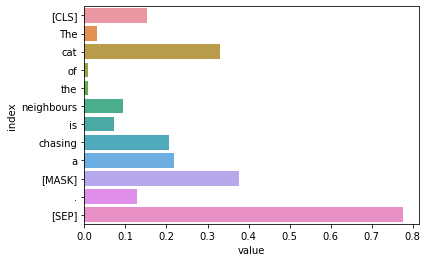

In [48]:
import seaborn as sns
ax = sns.barplot(x="value", y="index", data=df, order=df['index'])

In [46]:
sns.barplot?

In [12]:
def run_and_show(sentence, mask_tokens, reference=[tokenizer.unk_token_id], layer=None):
    if isinstance(mask_tokens, int):
        N = mask_tokens
        input_seq, mask_tokens, mask_index = prepare_data_for_sentence(sentence, N)
    else:
        N = len(mask_tokens)
        if isinstance(mask_tokens[0], str):
            mask_tokens = tokenizer.convert_tokens_to_ids(mask_tokens)
        input_seq, _, mask_index = prepare_data_for_sentence(sentence, N)

    attributions = []
    for ref in reference:
        attributions.append(run_attribution_model(input_seq, ref, mask_tokens, mask_index, layer))
    attributions = torch.stack(attributions).mean(axis=0)
    df = build_dataframe(attributions, input_seq, mask_tokens)
    plot = create_plot(df, mask_index, N)
    display(plot)
    return df, mask_index

In [49]:
def run_no_show(sentence, mask_tokens, reference=[tokenizer.unk_token_id], layer=None):
    if isinstance(mask_tokens, int):
        N = mask_tokens
        input_seq, mask_tokens, mask_index = prepare_data_for_sentence(sentence, N)
    else:
        N = len(mask_tokens)
        if isinstance(mask_tokens[0], str):
            mask_tokens = tokenizer.convert_tokens_to_ids(mask_tokens)
        input_seq, _, mask_index = prepare_data_for_sentence(sentence, N)

    attributions = []
    for ref in reference:
        attributions.append(run_attribution_model(input_seq, ref, mask_tokens, mask_index, layer))
    attributions = torch.stack(attributions).mean(axis=0)
    df = build_dataframe(attributions, input_seq, mask_tokens)
    return df, mask_index

In [8]:
from numpy.random import default_rng
rng = default_rng()
sample = rng.integers(model.config.vocab_size, size=20)
print(sample)

[16179  2161 11539 28167  6178 16557 17521 14984 15062  9672  2190 19319
 27078 13627 18551 21328 23656  4311 19743  4570]


In [9]:
[tokenizer.decode([token]) for token in sample]

['##rals',
 'Lake',
 'poison',
 '##®',
 'missions',
 'anterior',
 '1784',
 'Territorial',
 'crouched',
 '##ben',
 'list',
 'Levine',
 '##nosis',
 'Giles',
 '##zard',
 '##ieri',
 'culturally',
 'representing',
 'prospects',
 'employees']

In [51]:
import matplotlib

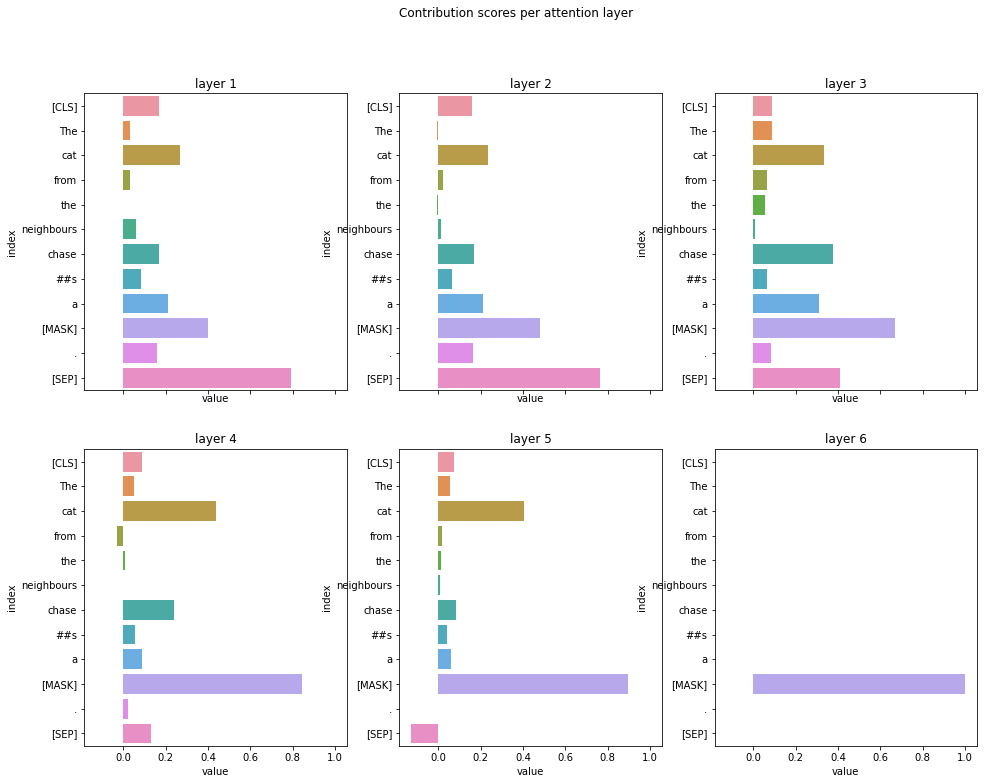

In [64]:
fig, axes = matplotlib.pyplot.subplots(2, 3, figsize=(16, 12), sharex=True)
fig.suptitle('Contribution scores per attention layer')
axes = axes.flatten()
for i in range(6):
    layer = getattr(model.distilbert.transformer.layer, f"{i}")
    df, _ = run_no_show(f"The cat from the neighbours chases a {tokenizer.mask_token}.", ["mouse"], reference=[tokenizer.unk_token_id], layer=layer)
    sns.barplot(ax=axes[i], data=df, x="value", y="index", order=df['index'])
    axes[i].set_title(f"layer {i+1}")

matplotlib.pyplot.show()

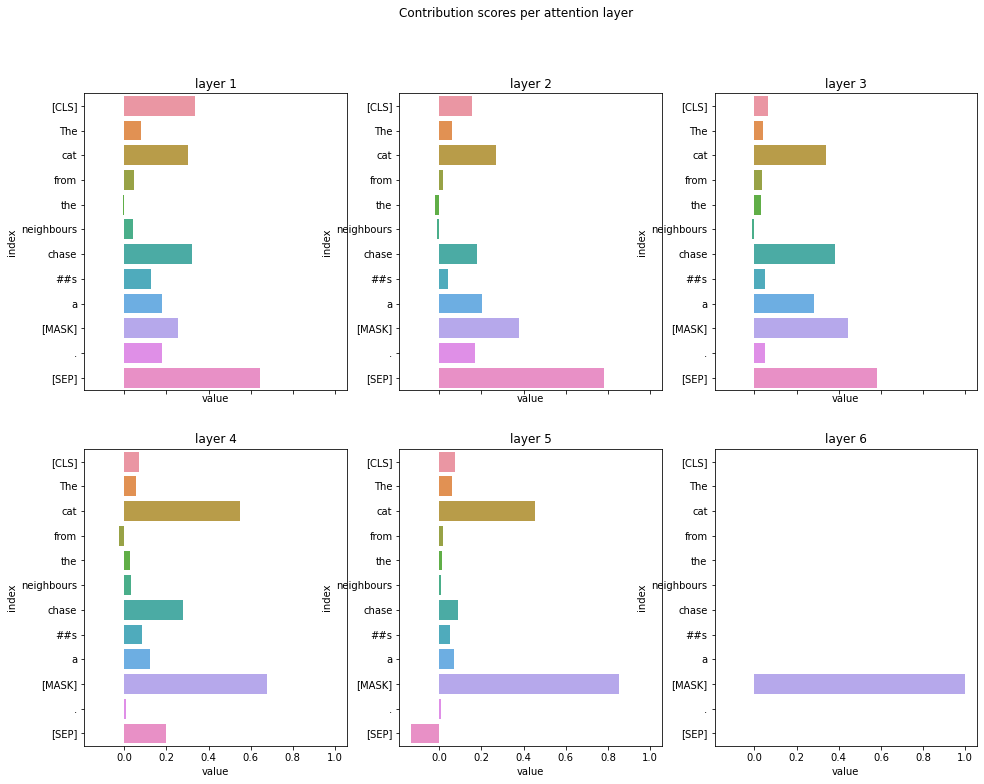

In [65]:
fig, axes = matplotlib.pyplot.subplots(2, 3, figsize=(16, 12), sharex=True)
fig.suptitle('Contribution scores per attention layer')
axes = axes.flatten()
for i in range(6):
    layer = getattr(model.distilbert.transformer.layer, f"{i}")
    df, _ = run_no_show(f"The cat from the neighbours chases a {tokenizer.mask_token}.", ["mouse"], reference=sample, layer=layer)
    sns.barplot(ax=axes[i], data=df, x="value", y="index", order=df['index'])
    axes[i].set_title(f"layer {i+1}")

matplotlib.pyplot.show()

In [68]:
df['rel_value'] = (df['value'].abs() / df['value'].abs().max()).round(2)
mask_index = 9

In [69]:
from IPython.display import HTML
import re

output = "<div style='font-size: 1.5em; padding: 1em; background-color: #CCC'>"
for v, g in df.groupby('variable'):
    output += "<div style='margin: 0.5em; padding: 0.5em; background-color: white; border: 3px solid #CCC; border-radius: 0.3em'>"
    for i, row in g.iterrows():
        if i % len(g) == mask_index:
            output += f"<span style='padding: 0.1em; text-decoration:underline;  background-color: rgba({'0,255,0' if row['value'] > 0 else '255,0,0'},{row['rel_value']});'>{row['variable']}</span>"
        else:
            word = row['index'].strip()
            word = re.sub(r'<', '&lt;', re.sub(r'>', '&gt;', word))
            output += f"<span style='padding: 0.1em; background-color: rgba({'0,255,0' if row['value'] > 0 else '255,0,0'},{row['rel_value']});'>{word}</span>"
    output += "</div>"
output += "</div>"
display(HTML(output))

In [70]:
model

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L